In [ ]:
# External libraries
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


Contribution by each feature: using SHAP

       feature  importance
0      MDEC-23    0.077390
9       GATS8s    0.035257
8       GATS8e    0.033024
11     VE3_Dzi    0.029215
5   SpMax7_Bhe    0.029130
4    CrippenMR    0.028867
6   SpMin1_Bhs    0.023180
10  SpMax5_Bhv    0.019249
2       ATSC8s    0.018357
3       VE3_Dt    0.018136
12       VPC-4    0.017629
7        C1SP2    0.015744
1       MATS2v    0.015087


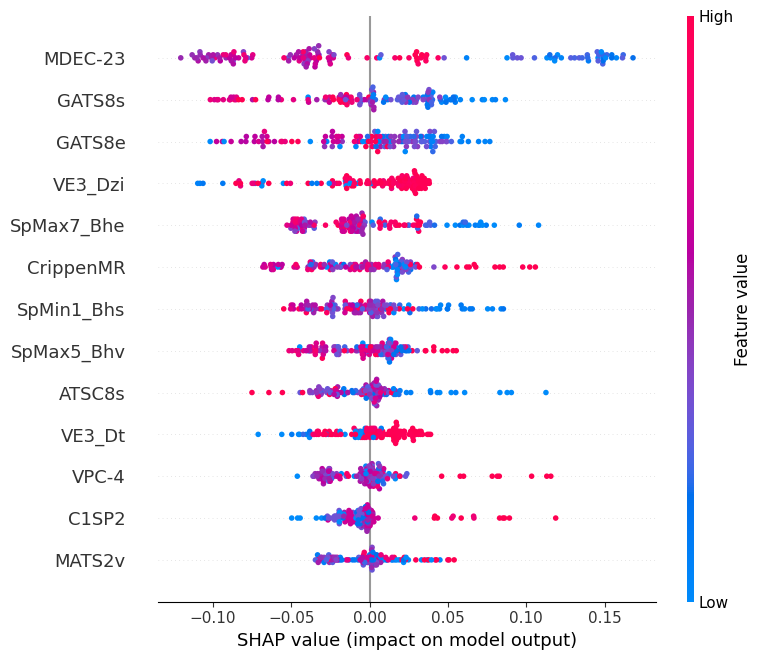

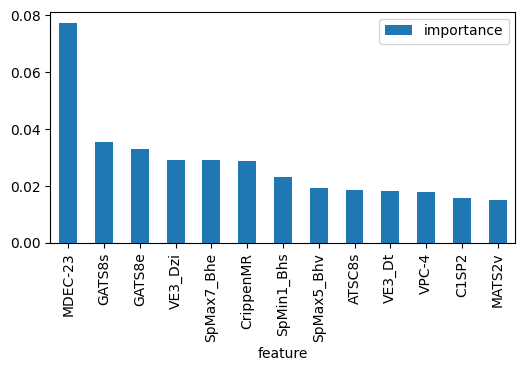

In [16]:
# Load dataset
dataset_save = "Dataset/Toxicity-13F.csv"
df = pd.read_csv(dataset_save)
df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0)

# Features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Convert categorical features if needed
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)

# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

# For binary classification, select positive class (class 1)
# shape: (n_samples, n_features)
shap_values_pos = shap_values.values[:, :, 1]

# Compute mean absolute SHAP value per feature
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(shap_values_pos).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Display SHAP importance
print(shap_importance)
shap.summary_plot(shap_values_pos, X_train, feature_names=X_train.columns)
shap_importance.plot(kind='bar', x='feature', y='importance', figsize=(6,3))

shap_importance['cumulative'] = shap_importance['importance'].cumsum() / shap_importance['importance'].sum()

Reduce dataset to only relevant features

In [13]:
top_features = shap_importance['feature'].head(5).tolist()
print("Top 8 features:", top_features)

# Create a new dataset with only top features + target
df_top = df[top_features + ['Class']]

# Save the new dataset
df_top.to_csv("Dataset/Toxicity-5F.csv", index=False)

# Optional: check the new dataset
print(df_top.head())

Top 8 features: ['MDEC-23', 'GATS8e', 'GATS8s', 'SpMax7_Bhe', 'CrippenMR']
   MDEC-23  GATS8e  GATS8s  SpMax7_Bhe  CrippenMR  Class
0  60.1757  1.0229  1.0575      3.4009     0.0000      1
1  44.5031  1.7155  1.7013      3.3611   172.2000      1
2  37.5488  0.6992  0.7828      3.2705   173.4028      1
3  40.5929  0.9951  1.0298      3.2748   177.2726      1
4  52.7343  0.7363  0.7427      3.4094   171.1315      1
